# DSI-18 - Capstone Project - Vegetable Classifier (1/2)
This is the capstone project for DSI-18 graduation. For my project, I have chosen to use deep learning to solve a common problem at the supermarket. The project is divided into 2 notebooks. This is part 1, where the image dataset is explored and a final image dataset will be prepared for training the model.

## Problem Statement
At the supermarket, most of the items are packed and their prices clearly labelled. There are however some grocery items, especially vegetables that needs to be weighed as they come in different sizes. For these vegetables, a price per kg is usually displayed and one will need to bring the vegetable to the weighing scale, select the vegetable from the screen and a label will then be printed based on the weight of the items on the scale and the type of vegetable selected.

**Problem**: There is usually a long list of vegetables to choose from, spanning multiple pages and it can be confusing as well as time consuming to find the right vegetable.

## Approach
Using Convolutional Neural Networks (CNN), I will build an image classification model to recognise some of the common vegetables found at the supermarket that needs to be weighed. The model will identify the vegetable and present to the customer so one need not scroll through the long list just to find the right vegetable. 

## Stakeholders
Possible stakeholders for this model includes all supermarket operators selling vegetables by weight. Deploying an image classification model which will recognise the vegetables will cut down on customers queueing to weigh the vegetables and increase customer satisfaction.

## Executive Summary

An image dataset consisting of 90K+ images belonging to 131 classes of fruits and vegetables found on Kaggle was used as the basis for the images needed for the training of the model. The 131 classes included both fruits and vegetables, and for the same vegetable, different varieties were classified separately. As the project is focused on classifying vegetables, 21 classes were shortlisted after excluding all fruits.

EDA was done for the 21 classes. Some classes were removed as they were not local, some were reclassed to reflect the correct class and some classes were merged as they would most likely be sold together. After EDA, 10 vegetable classes were finalized from the Kaggle dataset.

As quite a number of locally available vegetables were missing from the Kaggle dataset, 8 more classes were added. Photos of the 8 new classes were taken and further augmented using rotation, to maintain a well-balanced distribution of images for each class. An average of ~600 images per class was used for training.

A simple CNN model with 1 layer of 16 filters had yielded 0.916 validation accuracy, quite a high accuracy score. A 2nd model with 2 convolutional layers and 32 filters in the 2nd layer further improved the validation accuracy to 0.936. Finally, transfer learning from a VGG16 model with imagenet weights was used to train the model and validation accuracy increased further to 0.963. The model trained with VGG16 layers was chosen as the production model.

## Contents

- [Using Image Dataset From Kaggle](#Using-Image-Dataset-From-Kaggle)
    - [Checking the Zip Structure](#Checking-the-Zip-Structure)
    - [Loading the Image Dataset](#Loading-the-Image-Dataset)
- [EDA](#EDA)
    - [Vegetable Classes](#Vegetable-Classes)
        - [Tomato Classes](#Tomato-Classes)
        - [Cucumber Classes](#Cucumber-Classes)
        - [Onion Classes](#Onion-Classes)
        - [Potato Classes](#Potato-Classes)
- [Data Preparation](#Data-Preparation)
    - [New Classes](#New-Classes)
        - [Image Augmentation](#Image-Augmentation-for-New-Classes)
        - [Adding New Images to Dataset](#Add-Images-for-New-Classes)
- [Modeling](#Modeling)

## Importing Libraries

In [2]:
from zipfile import ZipFile
import pickle
import os, shutil
import glob

import pandas as pd
import numpy as np

import regex as re

import matplotlib.pyplot as plt
from matplotlib import image as img
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import experimental
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow import saved_model as tfsm

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('max_rows', None)

## Using Image Dataset From Kaggle
A dataset with 90,483 images and 131 classes of fruits and vegetables was found on [Kaggle](https://www.kaggle.com/moltean/fruits). The entire dataset was stored in a zip file and we will access all images using the zipfile library. Next we will explore the dataset to pick out the vegetables that we want to train the model with.

#### Checking the Zip Structure 

In [5]:
# Read contents of archive.zip
fruits = ZipFile('archive.zip')

In [6]:
# Check the contents of first 10 entries, image details start from 2nd item
fruits.filelist[:10]

[<ZipInfo filename='fruits-360/LICENSE' compress_type=deflate file_size=1143 compress_size=683>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/321_100.jpg' compress_type=deflate file_size=4836 compress_size=4650>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/322_100.jpg' compress_type=deflate file_size=4771 compress_size=4582>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/323_100.jpg' compress_type=deflate file_size=4801 compress_size=4612>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/324_100.jpg' compress_type=deflate file_size=4786 compress_size=4597>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/325_100.jpg' compress_type=deflate file_size=4755 compress_size=4572>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/326_100.jpg' compress_type=deflate file_size=4754 compress_size=4571>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/327_100.jpg' compress_type=deflate file_size=4771 compress_size=4589>,
 <ZipInfo filename='fruits-360/Test/Apple Braebur

Observations about the zip details:
- The first image starts from index 1, not 0
- The filename will identify each image
- In the filename, the images have been alloted as test or train
- The class is given as the folder name
- The image name itself does not identify the class

In [7]:
# Assign 1 as first entry 
first_entry = 1

In [8]:
# How many entries are there? 1st entry is for the details of the zip file
len(fruits.filelist)

90486

In [9]:
# This is the last entry in the dataset
fruits.filelist[-1]

<ZipInfo filename='fruits-360/test-multiple_fruits/tomatoes5.jpg' compress_type=deflate file_size=5146765 compress_size=5145315>

The last entry is an image for multiple fruits/vegetables. This will not be included as the consumer is expected to only place one type of vegetable at one time. I will look for the last entry for single item images.

In [10]:
# This is the last entry for single fruits/vegetables in one image, assign 90381 to last_entry
fruits.filelist[90380:90384]

[<ZipInfo filename='fruits-360/Training/Watermelon/r_9_100.jpg' compress_type=deflate file_size=5178 compress_size=4985>,
 <ZipInfo filename='fruits-360/papers/fruit_recognition_deep_learning.pdf' compress_type=deflate file_size=1102625 compress_size=1065687>,
 <ZipInfo filename='fruits-360/readme.md' compress_type=deflate file_size=8187 compress_size=3452>,
 <ZipInfo filename='fruits-360/test-multiple_fruits/Bananas(lady_finger)1.jpg' compress_type=deflate file_size=1402274 compress_size=1370009>]

In [11]:
last_entry = 90381 # add 1 to index value as index range does not include last index value

The last entry for single fruits/vegetables in one image is at index 90380.

Let's unzip the first and last images for a preview.

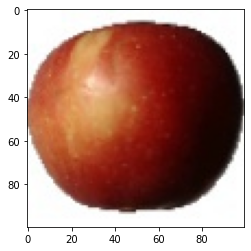

In [12]:
# Extract first image
link1 = fruits.extract(fruits.filelist[1],'./')
plt.imshow(plt.imread(link1));

In [13]:
plt.imread(link1).shape

(100, 100, 3)

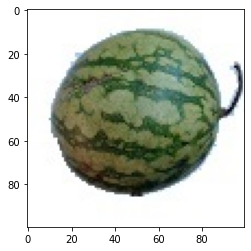

In [14]:
# Extract last image
link2 = fruits.extract(fruits.filelist[90380],'./')
plt.imshow(plt.imread(link2));

In [15]:
plt.imread(link2).shape

(100, 100, 3)

Both the first and last images have loaded successfully. Both image sizes are 100 x 100. Now let's load in the entire dataset.

#### Loading the Image Dataset

In [16]:
# Assign all images to list
fruits_list = fruits.filelist[first_entry:last_entry]

In [17]:
# Check the first 5 entries
fruits_list[:5]

[<ZipInfo filename='fruits-360/Test/Apple Braeburn/321_100.jpg' compress_type=deflate file_size=4836 compress_size=4650>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/322_100.jpg' compress_type=deflate file_size=4771 compress_size=4582>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/323_100.jpg' compress_type=deflate file_size=4801 compress_size=4612>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/324_100.jpg' compress_type=deflate file_size=4786 compress_size=4597>,
 <ZipInfo filename='fruits-360/Test/Apple Braeburn/325_100.jpg' compress_type=deflate file_size=4755 compress_size=4572>]

In [18]:
# Extract file paths for all images using regex
files = [re.findall("filename='(.*)'", str(file)) for file in fruits_list]
files[0]

['fruits-360/Test/Apple Braeburn/321_100.jpg']

In [19]:
# Check that all images have been included
len(files)

90380

The filename contains 3 types of information that is needed:
1. Train or test dataset to be used for
2. Class the image belongs to
3. Filename of the image
    
We will use regex to break down the filename into these 3 parts.

In [20]:
# Break down the string into 3 parts: 1. Train or test, 2. Class, 3. Image name (which will not be used) 
path = re.findall('fruits-360\/(.*)\/(.*)\/(.*)',files[0][0])
path[0]

('Test', 'Apple Braeburn', '321_100.jpg')

In [21]:
# Add images and details into separate arrays, for creating dataframe
images = []
dataset = []
name = []
for file in files:
    try:
        # images.append(img.imread(fruits.open(file[0], mode='r')))
        images.append(plt.imread(fruits.open(file[0], mode='r')))
        path = re.findall('fruits-360\/(.*)\/(.*)\/(.*)',file[0])
        dataset.append(path[0][0])      
        name.append(path[0][1])
    except:
        print(file[0])

In [22]:
# Check that all arrays have the same length
len(dataset), len(name), len(images)

(90380, 90380, 90380)

In [23]:
# Create the dataframe
df = pd.DataFrame({'dataset':dataset,
                   'name':name,
                   'image':images})

In [24]:
df.head()

dataset            name                                              image
0    Test  Apple Braeburn  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1    Test  Apple Braeburn  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2    Test  Apple Braeburn  [[[255, 255, 255], [255, 255, 255], [255, 255,...
3    Test  Apple Braeburn  [[[255, 255, 255], [255, 255, 255], [255, 255,...
4    Test  Apple Braeburn  [[[255, 255, 255], [255, 255, 255], [255, 255,...

We have now loaded entire image dataset as a dataframe.

## EDA
Next, we will explore the dataset and pick out the classes that we need for our modelling.

In [25]:
# Assign the unique classes
fruit_class = df['name'].unique()

In [26]:
len(fruit_class)

131

In [27]:
fruit_class

array(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1',
       'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith',
       'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
       'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2',
       'Apricot', 'Avocado ripe', 'Avocado', 'Banana Lady Finger',
       'Banana Red', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit',
       'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower',
       'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black',
       'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine',
       'Cocos', 'Corn Husk', 'Corn', 'Cucumber Ripe 2', 'Cucumber Ripe',
       'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla',
       'Grape Blue', 'Grape Pink', 'Grape White 2', 'Grape White 3',
       'Grape White 4', 'Grape White', 'Grapefruit Pink',
       'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki',
       'Kiwi', 'Kohlrabi', 'Kumquats', 'Lem

A total of 131 classes, as documented, of which majority are fruits. Let's sift out the vegetables.

### Vegetable Classes

In [28]:
# These are the list of name belonging to vegetables
veg_list = ['Cauliflower','Corn','Cucumber Ripe 2','Cucumber Ripe','Eggplant',
            'Onion Red Peeled','Onion Red','Onion White','Potato Red Washed','Potato Red',
            'Potato Sweet','Potato White','Tomato 1','Tomato 2','Tomato 3',
            'Tomato 4','Tomato Cherry Red','Tomato Heart','Tomato Maroon','Tomato Yellow',
            'Tomato not Ripened']

In [29]:
len(veg_list)

21

We are left with 21 classes of vegetables. However, I noticed some of the classes are just variants of the same vegetables, especially for tomato, there are 9 different classes. We will want to look at some of these images to see if they can be kept as separate classes or removed from the list to reduce unequal distribution of classes. First, let's create a vegetable subset of the dataframe to work with.

In [30]:
# Subset only vegetables, assign to df_final
df_veg = df[df['name'].isin(veg_list)]
df_veg.shape

(14304, 3)

In [31]:
# What's the distribution for the different classes
df_veg['name'].value_counts()

Tomato 3              984
Tomato 1              984
Cauliflower           936
Tomato Heart          912
Tomato 2              897
Tomato Cherry Red     656
Tomato 4              639
Tomato not Ripened    632
Eggplant              624
Cucumber Ripe 2       624
Tomato Yellow         612
Potato Red Washed     604
Corn                  600
Potato Sweet          600
Onion Red             600
Onion Red Peeled      600
Potato White          600
Potato Red            600
Onion White           584
Cucumber Ripe         522
Tomato Maroon         494
Name: name, dtype: int64

In [32]:
# This function will be used to display images in grid layout
def plot_images(images, names="", cols=5, suptitle=""):
    rows = int(np.ceil(len(images)/cols))
    fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(15,rows*1.5))
    ax = axes.ravel()
    if suptitle!="":
        fig.suptitle(suptitle, fontsize=14)

    for index in range(len(images)):
        ax[index].imshow(images[index])
        if names!="":
            ax[index].set_title(names[index])
        ax[index].set_xticks([])
        ax[index].set_yticks([])
    plt.tight_layout()
    plt.show()

#### Tomato Classes
There are 9 types of tomatoes. Let's explore the tomato images. To do that, we will create a tomato_preview subset from first 5 images from each tomato class.

In [33]:
tomato_classes = [name for name in veg_list if name.lower().startswith('tomato')]
tomato_classes

['Tomato 1',
 'Tomato 2',
 'Tomato 3',
 'Tomato 4',
 'Tomato Cherry Red',
 'Tomato Heart',
 'Tomato Maroon',
 'Tomato Yellow',
 'Tomato not Ripened']

In [34]:
df_veg[(df_veg['name']=='Tomato 1') & (df_veg['dataset']=='Training')].iloc[1,1]

'Tomato 1'

In [35]:
# Create separate arrays for each class and first 8 images
tomato_name = []
tomato_image = []
for name in tomato_classes:
    for i in range(8):
        tomato_name.append(name)
        tomato_image.append(df_veg[(df_veg['name']==name) & (df_veg['dataset']=='Training')].iloc[i,2])

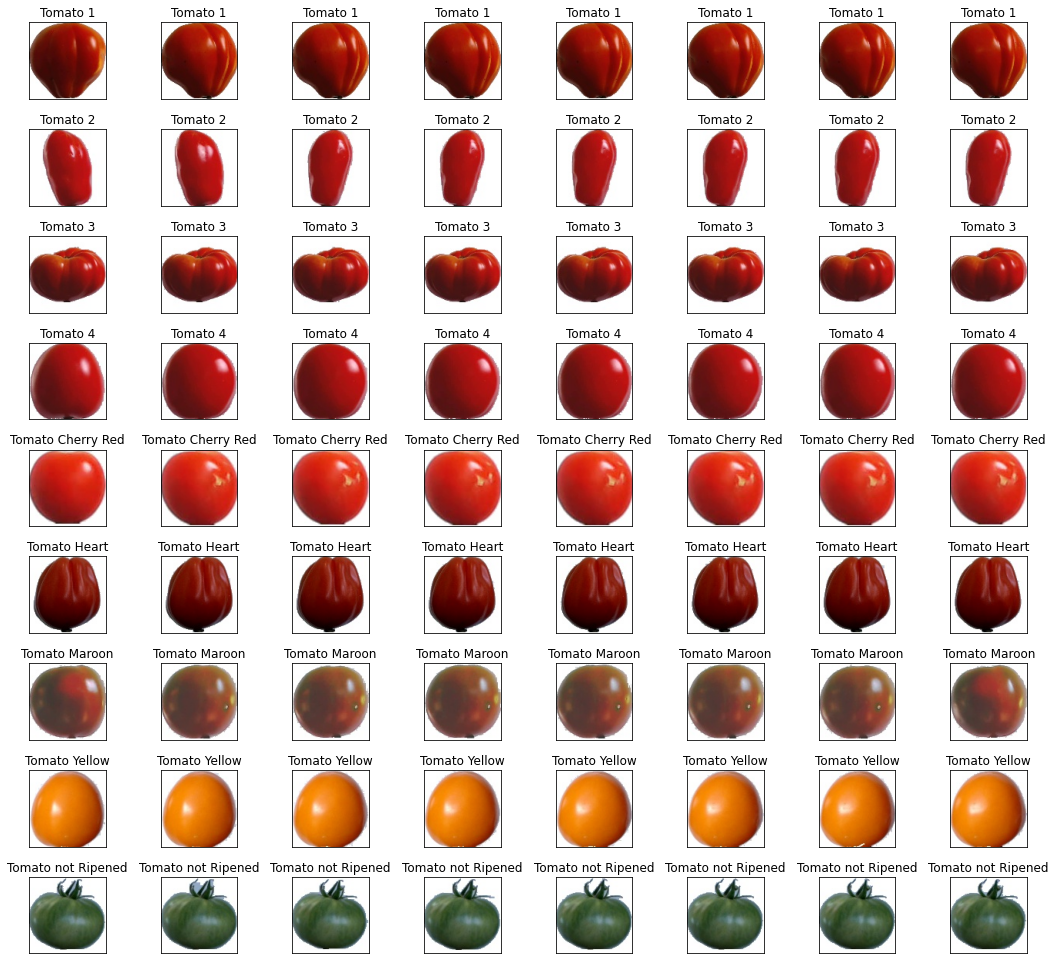

In [36]:
# Plot images, one row for each class
plot_images(tomato_image, tomato_name, 8)

Observations:
- `Tomato 4` and `Tomato Yellow` seems like the common type of tomato seen locally. We can merge these two tomato types as `Tomato`.
- `Tomato Cherry Red` is another commonly seen tomato type but it is usually not sold by weight, so we will exclude from our model.
- Rest of the tomato types are not commonly seen locally and will be excluded from the model.

Let's check out more images of `Tomato 4` and `Tomato Yellow` to see if they are really similar.

In [37]:
# Create tomato_4 and tomato_yellow subsets
tomato_4 = df_veg[(df_veg['name']=='Tomato 4') & (df_veg['dataset']=='Training')]
tomato_yellow = df_veg[(df_veg['name']=='Tomato Yellow') & (df_veg['dataset']=='Training')]

In [38]:
len(tomato_4), len(tomato_yellow)

(479, 459)

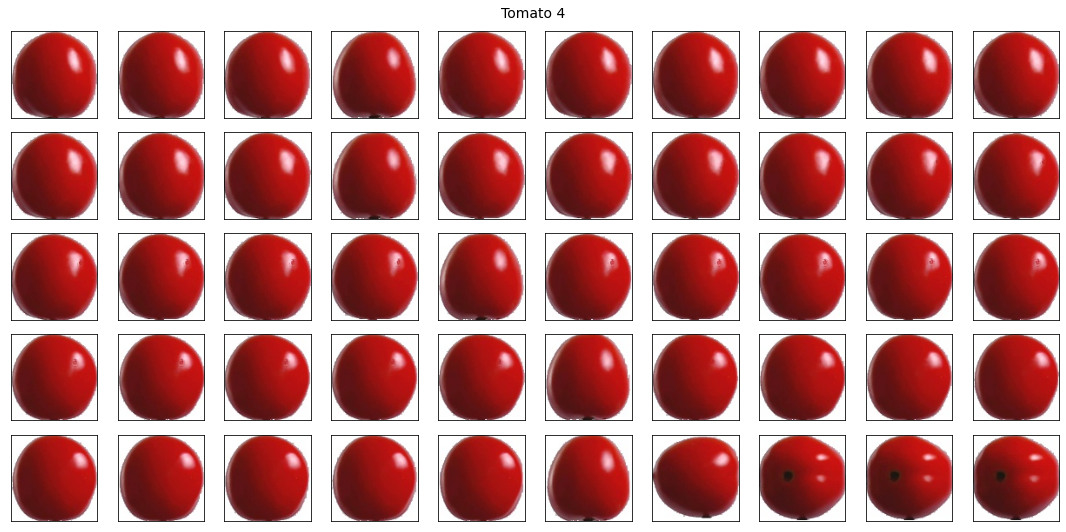

In [39]:
# Show 50 images of Tomato 4
plot_images(images=tomato_4['image'][200:250].values,names="",cols=10,suptitle="Tomato 4")

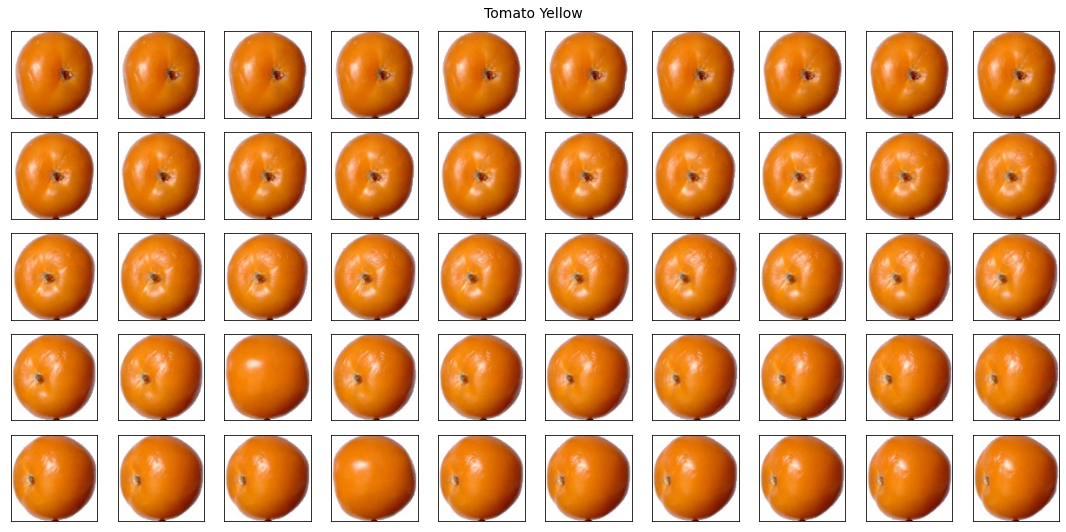

In [40]:
# Show 50 images of Tomato Yellow
plot_images(images=tomato_yellow['image'][200:250].values,names="",cols=10,suptitle="Tomato Yellow")

`Tomato 4` and `Tomato Yellow` are mostly similar except for the colour. I have decided to keep both as separate classes as `Tomato Yellow` would unlikely be sold together with red tomatos at the supermarket.

Changes as follows:
- `Tomato 4` => `Tomato`
- `Tomato Yellow` remain
- Drop rest of the tomato classes

In [41]:
# Keep only Tomato 4 and Tomato Yellow, drop the rest of tomato classes
remove_list = ['Tomato 1',
 'Tomato 2',
 'Tomato 3',
 'Tomato Cherry Red',
 'Tomato Heart',
 'Tomato Maroon',
 'Tomato not Ripened']

In [42]:
for item in remove_list:
    veg_list.remove(item)
veg_list

['Cauliflower',
 'Corn',
 'Cucumber Ripe 2',
 'Cucumber Ripe',
 'Eggplant',
 'Onion Red Peeled',
 'Onion Red',
 'Onion White',
 'Potato Red Washed',
 'Potato Red',
 'Potato Sweet',
 'Potato White',
 'Tomato 4',
 'Tomato Yellow']

#### Cucumber Classes
There are 2 classes for Cucumber, let's explore to see they can be merged.

In [43]:
# Create separate arrays for each class and first 8 images
cucumber_classes = ['Cucumber Ripe 2','Cucumber Ripe']
cucumber_name = []
cucumber_image = []
for name in cucumber_classes:
    for i in range(10):
        cucumber_name.append(name)
        cucumber_image.append(df_veg[(df_veg['name']==name) & (df_veg['dataset']=='Training')].iloc[i,2])

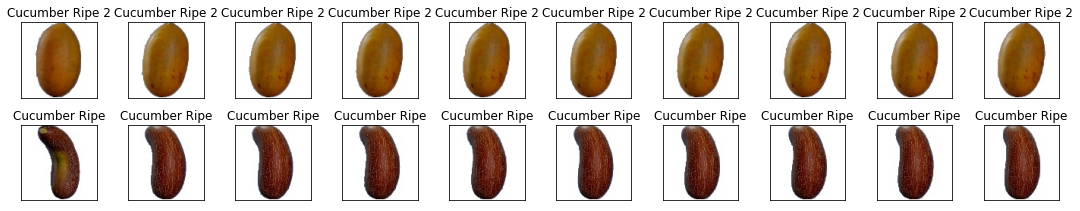

In [44]:
plot_images(images=cucumber_image,names=cucumber_name,cols=10,suptitle="")

These images don't look like cucumbers. Let's explore in more details.

In [45]:
# Create tomato_4 and tomato_yellow subsets
cucumber_1 = df_veg[(df_veg['name']=='Cucumber Ripe') & (df_veg['dataset']=='Training')]
cucumber_2 = df_veg[(df_veg['name']=='Cucumber Ripe 2') & (df_veg['dataset']=='Training')]

In [46]:
len(cucumber_1), len(cucumber_2)

(392, 468)

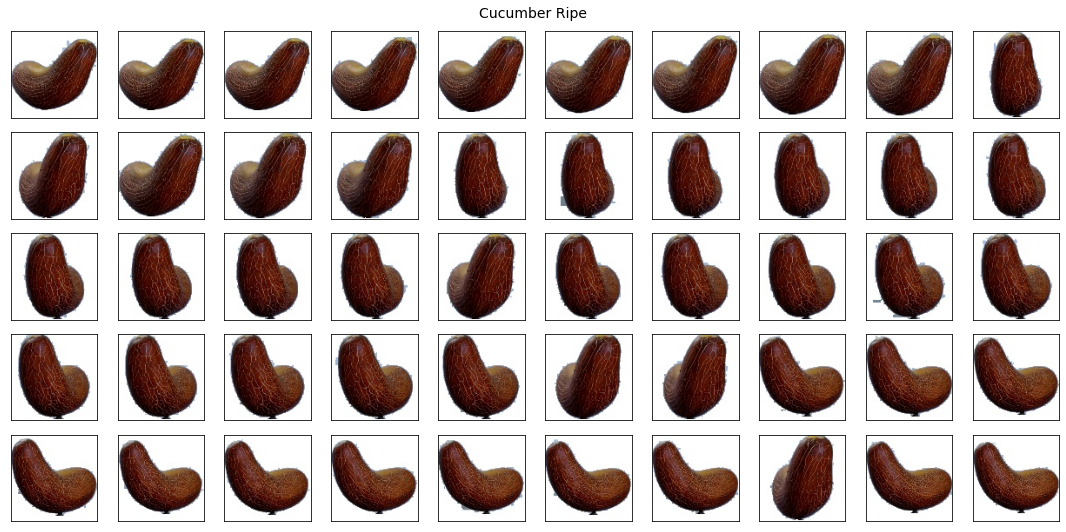

In [47]:
# Show 50 images of Cucumber 1
plot_images(images=cucumber_1['image'][300:350].values,names="",cols=10,suptitle="Cucumber Ripe")

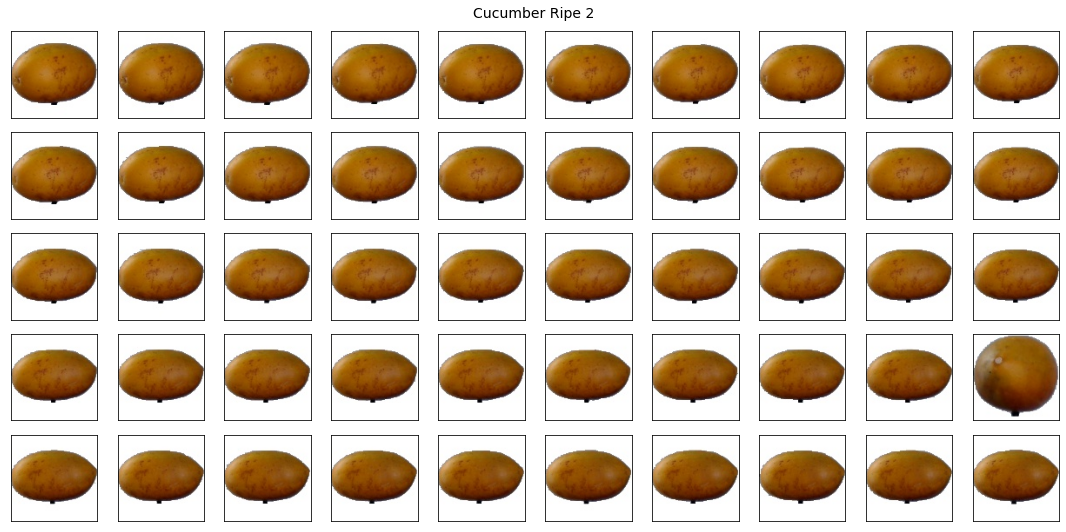

In [48]:
# Show 50 images of Cucumber 2
plot_images(images=cucumber_2['image'][300:350].values,names="",cols=10,suptitle="Cucumber Ripe 2")

Both cucumber classes do not look like the cucumbers that we see locally. Both classes will be dropped. We will add in our own cucumber images for training.

Changes as follows:
- Drop both cucumber classes

In [49]:
# Remove both cucumber classes
for item in cucumber_classes:
    veg_list.remove(item)
veg_list

['Cauliflower',
 'Corn',
 'Eggplant',
 'Onion Red Peeled',
 'Onion Red',
 'Onion White',
 'Potato Red Washed',
 'Potato Red',
 'Potato Sweet',
 'Potato White',
 'Tomato 4',
 'Tomato Yellow']

#### Onion Classes
Let's explore `Onion Red Peeled` and `Onion Red` to see if these classes can be merged. 

In [50]:
# Create separate arrays for each class and first 8 images
onion_classes = ['Onion Red Peeled','Onion Red','Onion White']
onion_name = []
onion_image = []
for name in onion_classes:
    for i in range(10):
        onion_name.append(name)
        onion_image.append(df_veg[(df_veg['name']==name) & (df_veg['dataset']=='Training')].iloc[i,2])

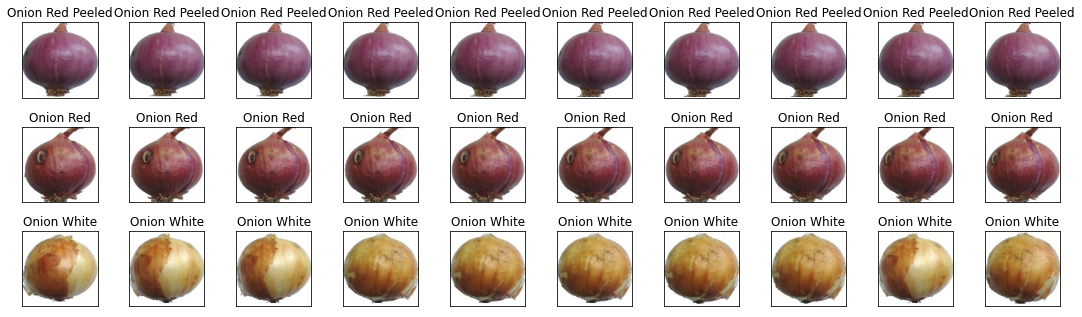

In [51]:
plot_images(images=onion_image,names=onion_name,cols=10,suptitle="")

The two classes of `Onion Red Peeled` and `Onion Red` looks similar, and could be mixed together in the supermarket. We will merge these two classes as `Onion Red`. `Onion White` will remain as a separate class.

Changes as follows:
- `Onion Red Peeled` => `Onion Red`
- `Onion White` remain

#### Potato Classes
There are 4 classes of potatos, let's explore them and see if any class should be merged.

In [52]:
# Create separate arrays for each class and first 8 images
potato_classes = ['Potato Red Washed','Potato Red','Potato Sweet','Potato White']
potato_name = []
potato_image = []
for name in potato_classes:
    for i in range(10):
        potato_name.append(name)
        potato_image.append(df_veg[(df_veg['name']==name) & (df_veg['dataset']=='Training')].iloc[i,2])

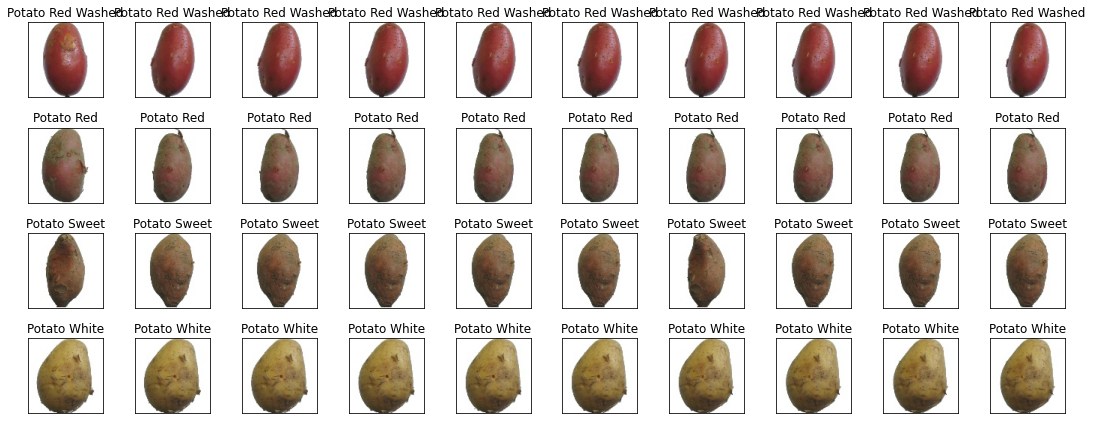

In [53]:
plot_images(images=potato_image,names=potato_name,cols=10,suptitle="")

`Potato Red` and `Potato Sweet` looks almost identical. It will be hard to differentiate between the two. We will reclassify `Potato Red Washed` as `Potato Red` and drop the original `Potato Red` class so as not to confuse with `Potato Sweet`. `Potato White` will remain as a class.

Changes as follows:
- Change `Potato Red Washed` to `Potato Red`
- Drop original `Potato Red`
- `Potato Sweet` and `Potato White` remain

In [54]:
# Remove potato red classes
veg_list.remove("Potato Red")
veg_list

['Cauliflower',
 'Corn',
 'Eggplant',
 'Onion Red Peeled',
 'Onion Red',
 'Onion White',
 'Potato Red Washed',
 'Potato Sweet',
 'Potato White',
 'Tomato 4',
 'Tomato Yellow']

## Data Preparation
Next, we will prepare the following:
1. Prepare an image dataset with only the classes we need
2. Update the class names where applicable
3. Insert a class code column as integer type 

With the final list of vegetables, let's create a dictionary of the different types.

In [55]:
# create dictionary to map vegetable names
veg_dict = {veg_list[i]:veg_list[i].lower().replace(" ","_") for i in range(len(veg_list))}

In [56]:
veg_dict

{'Cauliflower': 'cauliflower',
 'Corn': 'corn',
 'Eggplant': 'eggplant',
 'Onion Red Peeled': 'onion_red_peeled',
 'Onion Red': 'onion_red',
 'Onion White': 'onion_white',
 'Potato Red Washed': 'potato_red_washed',
 'Potato Sweet': 'potato_sweet',
 'Potato White': 'potato_white',
 'Tomato 4': 'tomato_4',
 'Tomato Yellow': 'tomato_yellow'}

In [57]:
# Update classes to new class where applicable
veg_dict['Onion Red Peeled'] = 'onion_red'
veg_dict['Potato Red Washed'] = 'potato_red'
veg_dict['Tomato 4'] = 'tomato'
veg_dict

{'Cauliflower': 'cauliflower',
 'Corn': 'corn',
 'Eggplant': 'eggplant',
 'Onion Red Peeled': 'onion_red',
 'Onion Red': 'onion_red',
 'Onion White': 'onion_white',
 'Potato Red Washed': 'potato_red',
 'Potato Sweet': 'potato_sweet',
 'Potato White': 'potato_white',
 'Tomato 4': 'tomato',
 'Tomato Yellow': 'tomato_yellow'}

In [58]:
# Get unique class values, sorted by name
veg_ref = list(set(veg_dict.values()))
veg_ref.sort()
veg_ref

['cauliflower',
 'corn',
 'eggplant',
 'onion_red',
 'onion_white',
 'potato_red',
 'potato_sweet',
 'potato_white',
 'tomato',
 'tomato_yellow']

In [59]:
# Create dictionary of vegetable classes and its corresponding integer code 
veg_ref = {veg_ref[i]:i for i, veg in enumerate(veg_ref)}

In [60]:
# Convert dictionary of codes into dataframe 
veg_pd = pd.DataFrame.from_dict(veg_ref, orient='index', columns=['code'])
veg_pd

code
cauliflower       0
corn              1
eggplant          2
onion_red         3
onion_white       4
potato_red        5
potato_sweet      6
potato_white      7
tomato            8
tomato_yellow     9

#### Subset with Final List of Vegetables

In [61]:
# Subset only selected vegetables, assign to df_final
df_final = df_veg[df_veg['name'].isin(veg_list)]
df_final.shape

(6999, 3)

In [62]:
# What's the distribution for the different classes
df_final['name'].value_counts()

Cauliflower          936
Tomato 4             639
Eggplant             624
Tomato Yellow        612
Potato Red Washed    604
Onion Red            600
Potato Sweet         600
Corn                 600
Onion Red Peeled     600
Potato White         600
Onion White          584
Name: name, dtype: int64

In [63]:
# Map name to new class names using veg_dict
df_final['name'] = df_final['name'].map(veg_dict)

In [64]:
# What's the distribution for the different classes after updating
df_final['name'].value_counts()

onion_red        1200
cauliflower       936
tomato            639
eggplant          624
tomato_yellow     612
potato_red        604
potato_white      600
potato_sweet      600
corn              600
onion_white       584
Name: name, dtype: int64

In [65]:
# Add Class Code to df_final using veg_pd 
df_final = pd.merge(df_final, veg_pd, how='left', left_on='name', right_index=True)

In [66]:
# Check that code has been added correctly
df_final.iloc[:2]

dataset         name                                              image  \
4055    Test  cauliflower  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
4056    Test  cauliflower  [[[255, 255, 253], [255, 255, 253], [255, 255,...   

      code  
4055     0  
4056     0

In [67]:
# Drop the name column
df_final = df_final.drop('name', axis=1)

## New Classes
As the Kaggle dataset did not include some of the common local vegetable classes that might require weighing at the supermarket, we will add 8 new classes to enhance the model's capabiities. Some 20~30 images were taken for each of these new classes and augmented with rotation to increase images for each new class to around 300. 

In [68]:
# add new classes ['bittergourd','pumpkin','white_gourd','broccoli','cucumber','cucumber_japanese','brinjal','ginger']
veg_names = list(veg_pd.index)
veg_codes = list(veg_pd['code'])
veg_names.extend(['bittergourd',
                  'pumpkin',
                  'white_gourd',
                  'broccoli',
                  'cucumber',
                  'cucumber_japanese',
                  'brinjal',
                  'ginger'])
veg_codes.extend([10,11,12,13,14,15,16,17])

In [69]:
# Create the updated veg_pd
veg_pd = pd.DataFrame(veg_codes, index=veg_names, columns=['code'])
veg_pd

code
cauliflower           0
corn                  1
eggplant              2
onion_red             3
onion_white           4
potato_red            5
potato_sweet          6
potato_white          7
tomato                8
tomato_yellow         9
bittergourd          10
pumpkin              11
white_gourd          12
broccoli             13
cucumber             14
cucumber_japanese    15
brinjal              16
ginger               17

In [70]:
# Save the class codes as a pickle for use in the production model
outfile = open('./models/veg_class.pkl','wb')
pickle.dump(veg_pd, outfile)
outfile.close()

### Image Augmentation for New Classes
The number of images for the classes from the Kaggle dataset is >400 while the new images I took around 30. This presents a terribly imbalanced dataset. By augmenting the images using rotation, the imbalance is greatly reduced as I now have ~400 images for each of the new classes as well.

In [72]:
# Get path for image samples
root_dir = os.getcwd()
inputFolder = root_dir + '\\samples'
inputFolder

'D:\\GA\\dsi18-workarea\\capstone\\fruits & vegetables\\samples'

In [215]:
# Rotate and resize the image to 100 x 100 and save the new images in rotate folder
for file in glob.glob(inputFolder + "\\*.JPG"):
    # get the name of the image
    results = re.findall(r'[\\](\w*)', file)
    filename = results[-1] 
    
    pic = cv2.imread(file)
    height, width = pic.shape[:2]
    
    # Rotate image from 10 to 360 degrees
    # for angle in np.arange(0,360,10): # for train
    for angle in np.arange(0,360,40): # for test
        rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
        rotated_image = cv2.warpAffine(pic,rotation_matrix,(width,height), borderValue=(150,150,150))
        resized_image = cv2.resize(rotated_image,(100,100))
        
        # Save the new file in rotate folder
        newfile = root_dir + "\\rotate\\" + filename + "a" + str(angle) + ".jpg"
        cv2.imwrite(newfile, resized_image)

cv2.destroyAllWindows()

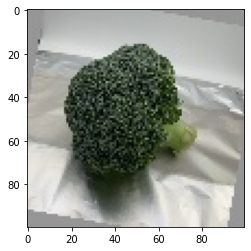

In [73]:
# Show sample of rotated image
for file in glob.glob(root_dir + "\\rotate\\*.JPG"):
    pic = plt.imread(file)
    plt.imshow(pic)
    plt.show()
    break

### Add Images for New Classes

In [70]:
# add new images to training set
import_dir = 'train_samples\\'
images = []
datasets = []
codes = []

for name in glob.glob(import_dir + '*.jpg'):
    results = re.findall(r'\\(.*)_[\d*].', name)
    images.append(img.imread(name))
    datasets.append('Training')
    
    # map name to integer code
    codes.append(veg_pd.loc[results[0], 'code'])

In [71]:
# add new images to test set
import_dir = 'test_samples\\'
for name in glob.glob(import_dir + '*.jpg'):
    results = re.findall(r'\\(.*)_[\d*].', name)
    images.append(img.imread(name))
    datasets.append('Test')
    
    # map name to integer code
    codes.append(veg_pd.loc[results[0], 'code'])

In [72]:
# Create new_df with new classes
new_df = pd.DataFrame({'dataset':datasets,
                       'code':codes,
                       'image':images})

In [73]:
# Merge the Kaggle dataset with new_df
df_merge = pd.concat([df_final, new_df])

In [82]:
df_merge['code'].value_counts()

3     2580
7     1175
0     1120
8      965
16     930
14     763
17     684
13     640
2      624
15     614
9      612
5      604
1      601
6      600
4      584
11     414
10     380
12     322
Name: code, dtype: int64

In [83]:
len(df_merge)

14212

### Save Merged Image Dataset as Pickle 

In [75]:
# save df as pickle file
outfile = open('./datasets/data.pkl', 'wb')
pickle.dump(df_merge, outfile)
outfile.close()

In [84]:
df_merge.head()

dataset                                              image  code
4055    Test  [[[255, 255, 255], [255, 255, 255], [255, 255,...     0
4056    Test  [[[255, 255, 253], [255, 255, 253], [255, 255,...     0
4057    Test  [[[255, 255, 255], [255, 255, 255], [255, 255,...     0
4058    Test  [[[255, 255, 255], [255, 255, 255], [255, 255,...     0
4059    Test  [[[255, 255, 255], [255, 255, 255], [255, 255,...     0

## Modeling
[Continue to modeling](./02_modeling.ipynb)